<a href="https://colab.research.google.com/github/uervitonsantos/Algoritmo-PSO-para-otimiza-o-de-custo-de-manuten-o-preventiva/blob/main/algoritmo_pso_para_otimiza_o_de_custo_de_manuten_o_preventiva_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
from scipy.optimize import minimize
from scipy.stats import poisson
import pandas as pd
import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

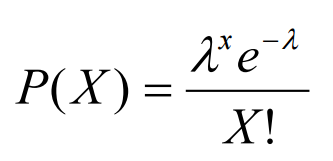

In [ ]:
# Função de verossimilhança para distribuição de Poisson
def poisson_likelihood(lam, data):
    log_likelihood = np.sum(poisson.logpmf(data, lam))
    return log_likelihood

In [ ]:
# Função de verossimilhança para distribuição de lei de potência
def powerlaw_likelihood(params, data):
    alpha, xmin = params
    n = len(data)
    lam = (alpha - 1) / xmin * (data ** (1 - alpha))
    log_likelihood = np.sum(np.log(lam))
    return -log_likelihood

In [ ]:
# Função de verossimilhança combinada para distribuição de lei de potência e Poisson
def combined_likelihood(params, data):
    alpha, xmin, lam = params
    return powerlaw_likelihood([alpha, xmin], data) + poisson_likelihood(lam, data)

In [ ]:
# Dados observados de eventos raros
events = pd.read_csv("/content/data.csv", sep=";")
events.head()

In [ ]:
data = events['t']

In [ ]:
%%capture
# Estimando os parâmetros da distribuição de lei de potência
initial_guess = [1, 10]  # Chute inicial para os parâmetros alpha e xmin
result_powerlaw = minimize(powerlaw_likelihood, initial_guess, args=(data,), method='BFGS')
alpha_hat, xmin_hat = result_powerlaw.x

In [ ]:
# Estimando o parâmetro lambda da distribuição de Poisson usando a função de verossimilhança combinada
def combined_likelihood_poisson(params, data):
    alpha, xmin, lam = params
    return combined_likelihood([alpha, xmin, lam], data)

In [ ]:
# Função de penalidade para restrição de limites para lambda
def lambda_penalty(params, data, lambda_penalty_weight=1e6):
    alpha, xmin, lam = params
    lam_diff = lam - round(lam)  # Diferença entre lam e seu valor arredondado
    penalty = lambda_penalty_weight * lam_diff**2  # Função de penalidade quadrática
    return penalty

In [ ]:
# Função para minimizar a verossimilhança combinada com lambda como parâmetro inteiro
def minimize_combined_likelihood_poisson(params, data):
    alpha, xmin, lam = params
    result_combined = minimize(
        fun=lambda params: combined_likelihood_poisson(params, data) + lambda_penalty(params, data),
        x0=[alpha_hat, xmin_hat, np.mean(data)],  # Chute inicial para os parâmetros alpha, xmin e lambda
        method='BFGS'
    )
    alpha, xmin, lam = result_combined.x
    lam = round(lam)  # Arredonda o valor de lambda para o inteiro mais próximo
    return alpha, xmin, lam

In [ ]:
# Estimando o parâmetro lambda como o valor inteiro que minimiza a função de verossimilhança combinada
alpha_hat, xmin_hat, lam_hat = minimize_combined_likelihood_poisson([alpha_hat, xmin_hat, np.mean(data)], data)

In [ ]:
print("Parâmetros estimados:")
print("Alpha (coeficiente de inclinação da lei de potência):", alpha_hat)
print("Xmin (valor mínimo do evento):", xmin_hat)
print("Lambda (taxa média de ocorrência da distribuição de Poisson):", (lam_hat))

In [ ]:
# Valores estimados dos parâmetros
parametros = ['alpha_hat', 'xmin_hat', 'lam_hat']
valores = [alpha_hat, xmin_hat, lam_hat]

# Plotando os resultados
plt.figure(figsize=(8, 6))
plt.plot(parametros, valores, marker='o')
plt.xlabel('Parâmetro')
plt.ylabel('Valor Estimado')
plt.title('Estimativa dos Parâmetros')
plt.grid(True)
plt.show()

In [ ]:
# A função custo_manutencao representa a função de custo que você deseja minimizar. 
# Ela recebe como entrada um vetor x que contém as variáveis de decisão do problema.

def custo_manutencao(x):

    nivel_severidade = events['s'] # gral de severidade aplicado na manutenção
    custo_dia  = 4000 # custo por dia de inatividade do sistema
    custo_manutencao = events['c'] # custo médio das manutenções
    # degradacao_sistema

    # nivel_severidade = random.choice(nivel_severidade) # o gral de severidade aplicado na manutenção pode varia em uma escala de [10...100] %
    #custo_manutencao  = ((custo_dia*nivel_severidade)/100) # custo médio das manutenções
    custo_manutencao = np.maximum(0, (1 - np.exp(-x[0] / 20)) * x[0] * np.exp(-x[0] / 100)) # Essa linha calcula o custo médio das manutenções com base em um valor de entrada x[0]
    system_degradation = np.maximum(0, 1 - x[0] / 10) * np.exp(2 * np.power((x[0] - 10) / 10, 3)) # Essa linha calcula um valor relacionado à degradação de um sistema com base em um valor de entrada x[0]
 
    custo = (system_degradation + custo_manutencao)

    return custo

In [ ]:
# 1 - 'cost_maintenance = np.maximum(0, (1 - np.exp(-x[0] / 20)) * x[0] * np.exp(-x[0] / 100))': Essa linha calcula o custo médio das manutenções 
# com base em um valor de entrada x[0]. A fórmula é composta de várias operações matemáticas. Vamos entender cada uma delas:

# * '(1 - np.exp(-x[0] / 20))': Calcula '1 - exp(-x[0] / 20)', onde 'exp()' é a função exponencial. Essa parte da fórmula está relacionada a uma 
# função de degradação ou desgaste do sistema, onde um valor maior de x[0] resulta em um custo menor de manutenção.

# * 'x[0] * np.exp(-x[0] / 100)': Calcula 'x[0] * exp(-x[0] / 100)', onde 'x[0]' é multiplicado pela função exponencial. Essa parte da fórmula está 
# relacionada a um custo variável de manutenção que é afetado pelo valor de 'x[0]', com um decaimento exponencial.

# 'np.maximum(0, ...)': Aplica uma função de máximo, onde o resultado da multiplicação anterior é comparado com zero e o maior valor é retornado. 
# Isso garante que o custo de manutenção seja sempre maior ou igual a zero.

# 2 - 'system_degradation = np.maximum(0, 1 - x[0] / 10) * np.exp(2 * np.power((x[0] - 10) / 10, 3))': Essa linha calcula um valor relacionado à degradação 
# de um sistema com base em um valor de entrada 'x[0]'. A fórmula é composta de várias operações matemáticas. Vamos entender cada uma delas:

# '1 - x[0] / 10': Calcula '1 - x[0] / 10, onde x[0]' é dividido por 10 e subtraído de 1. Essa parte da fórmula está relacionada a uma função de degradação 
# ou desgaste do sistema, onde um valor maior de 'x[0]' resulta em uma degradação menor do sistema.

# * 'np.maximum(0, ...)': Aplica uma função de máximo, onde o resultado da subtração anterior é comparado com zero e o maior valor é retornado. Isso garante 
# que o valor de degradação do sistema seja sempre maior ou igual a zero.

# * 'np.power((x[0] - 10) / 10, 3)': Calcula a potência de 3 do valor '(x[0] - 10) / 10, onde x[0]' é subtraído de 10 e o resultado é dividido por 10. Essa 
# parte da fórmula está relacionada a uma função de crescimento ou aumento da degradação do sistema.


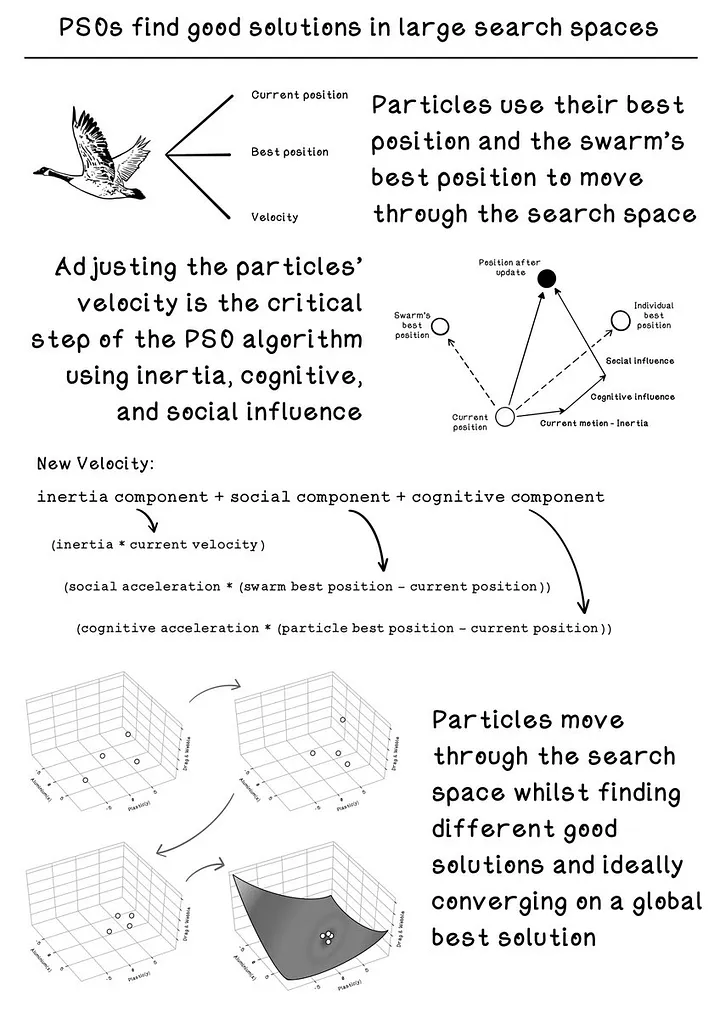

In [ ]:
# Define o tamanho da população e o número de dimensões
tam_populacao = 10
num_dimensoes = 5

# Define os limites inferior e superior para as dimensões
limites_inferiores = np.zeros(num_dimensoes)
limites_superiores = np.ones(num_dimensoes) * 10

In [ ]:
# Define a função de atualização da posição do enxame
def atualiza_posicao_enxame(x, v, p_best, g_best, w, c1, c2):
    r1 = np.random.rand(num_dimensoes)
    r2 = np.random.rand(num_dimensoes)
    v = w*v + c1*r1*(p_best - x) + c2*r2*(g_best - x)
    x = x + v
    return x, v

In [ ]:
# Define os parâmetros do PSO
num_iteracoes = 100
w = 0.5
c1 = 1.5
c2 = 1.5

In [ ]:
# Inicializa a população e a velocidade do enxame
populacao = np.random.uniform(limites_inferiores, limites_superiores, (tam_populacao, num_dimensoes))
velocidade = np.zeros((tam_populacao, num_dimensoes))

In [ ]:
# Inicializa as melhores posições da população e a melhor posição global
p_best = populacao.copy()
custo_p_best = np.zeros(tam_populacao)
for i in range(tam_populacao):
    custo_p_best[i] = custo_manutencao(populacao[i])
g_best_index = np.argmin(custo_p_best)
g_best = p_best[g_best_index].copy()

# Lista para armazenar o custo de cada iteração
custo_minimo_iteracoes = []

# Executa o PSO
for i in range(num_iteracoes):
    for j in range(tam_populacao):
        custo_j = custo_manutencao(populacao[j])
        if custo_j < custo_p_best[j]:
            p_best[j] = populacao[j].copy()
            custo_p_best[j] = custo_j
        if custo_j < custo_manutencao(g_best):
            g_best = populacao[j].copy()
    populacao, velocidade = atualiza_posicao_enxame(populacao, velocidade, p_best, g_best, w, c1, c2)

    # Adiciona o custo da iteração à lista
    custo_minimo_iteracao = custo_manutencao(g_best)
    custo_minimo_iteracoes.append(custo_minimo_iteracao)

In [ ]:
# Exibe a solução encontrada
print("Melhor posição encontrada:", g_best)
print("Custo mínimo encontrado:", custo_manutencao(g_best))

In [ ]:
# Plota o gráfico do custo em função do número de iterações
fig_verify = plt.figure(figsize=(20, 5))
plt.plot(range(1, num_iteracoes+1), custo_minimo_iteracoes, color="red")
plt.xlabel('Número de iterações')
plt.ylabel('Custo mínimo')
plt.title('Convergência do PSO para minimização do custo de manutenção preventiva')
plt.xlim(0)
plt.grid(True)
plt.show()

**Github:** https://github.com/franciscoicmc/simulacao/blob/master/Processo-Poisson.ipynb

**Medium:** https://medium.com/towards-data-science/complete-step-by-step-particle-swarm-optimization-algorithm-from-scratch-74471d064f91#caa0

**GitHub:** https://github.com/greyhub/MSOLab/blob/main/PSO/pso-customize.ipynb

**GitHub:** https://github.com/Azure/lstms_for_predictive_maintenance/blob/master/Deep%20Learning%20Basics%20for%20Predictive%20Maintenance.ipynb

**GitHub:** https://github.com/umbertogriffo/Predictive-Maintenance-using-LSTM

https://towardsdatascience.com/fine-tuning-the-strategy-using-a-particle-swarm-optimization-a5a2dc9bd5f1

https://towardsdatascience.com/particle-swarm-optimization-visually-explained-46289eeb2e14

https://gallery.azure.ai/Experiment/Predictive-Maintenance-Step-2A-of-3-train-and-evaluate-regression-models-2

**PySwarms’s documentation:** https://pyswarms.readthedocs.io/en/latest/examples/tutorials/custom_optimization_loop.html

https://www.youtube.com/watch?v=xEQv9YdvRiA